## 2: Dataset2 3-Digit Classification

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

Shape: (84, 84)
Range: 0.0-1.0


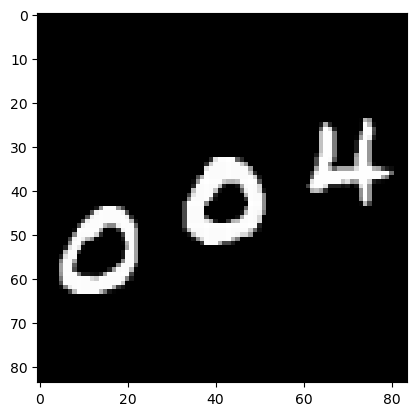

In [2]:
img = mpimg.imread('dataset2/triple_mnist/train/004/14_004.png')
imgplot = plt.imshow(img, cmap='gray')
print('Shape: ' + str(img.shape))
print('Range: ' + str(np.min(img)) + '-' + str(np.max(img)))

### Data Pre-Processing

In [3]:
import os

def get_data(subdir):
    # this imports all the data from a specified subdirectory and places into [img, label] pairs in a list.
    dir = 'dataset2/triple_mnist'  # base directory for all data.
    data = []
    labels = os.listdir(os.path.join(dir, subdir))  # get all folders (labels) in the subdirectory.
    
    for label in labels:  # cycles through each folder (label).
        class_num = int(label)

        for img in os.listdir(os.path.join(dir, subdir, label)):  # cycles through each png.
            try:
                img_arr = plt.imread(os.path.join(dir, subdir, label, img))  # reads image data.
                data.append([img_arr.flatten(), class_num])  # appends flattened image data with label.
            except Exception as e:
                print(e)

    return data

In [4]:
train_raw = get_data('train')
val_raw = get_data('val')
test_raw = get_data('test')

In [26]:
combined_data = train_raw + val_raw + test_raw

In [31]:
def prop_split_data(data, labels, r_train, r_val, r_test):
    # this takes the combined data and randomly splits it into train, val, and test sets, each containing the right amount of each label.

    if r_train + r_val + r_test != 1:
        raise Exception("Ratios do not sum to 1.")

    train = []
    val = []
    test = []

    for lab in labels:
        isolated_data = [x for x in data if x[1]==lab]
        n = len(isolated_data)
        random.shuffle(isolated_data)

        train.extend(isolated_data[-(int(n*r_train)):])
        del isolated_data[-(int(n*r_train)):]
        val.extend(isolated_data[-(int(n*r_val)):])
        del isolated_data[-(int(n*r_val)):]
        test.extend(isolated_data[-(int(n*r_test)):])
        del isolated_data[-(int(n*r_test)):]

    return train, val, test

In [32]:
new_train, new_val, new_test = prop_split_data(combined_data, np.arange(0, 1000), r_train=0.64, r_val=0.16, r_test=0.2)

In [55]:
def organise_data(data):
    # takes in data in shape (?,2), with each entry being in form [flattened_img, label].
    X = []
    y = []

    for img, label in data:
        X.append(img)
        y.append(label)

    return np.array(X), np.array(y)

In [56]:
X_train, y_train = organise_data(train_raw)

In [57]:
# NUMBERS PER SET
# train: 640 (64 needed of each number per set)
# test: 200 (20)
# val: 160 (16)

(160,)
